In [1]:
import pymongo
from pymongo import MongoClient
import pandas as pd
import numpy as np
import json
import re
from textblob import TextBlob
import matplotlib.pyplot as plt 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.text import Text
import string, re
import math 
import datetime
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates
import matplotlib.dates as dates
from textblob.classifiers import NaiveBayesClassifier

In [2]:
pd.set_option('max_colwidth', 1000)
pd.options.display.max_rows = 1000
data = pd.read_csv("en_twitter.csv")

In [3]:
data

,Unnamed: 0,_id,timestamp_ms,text
0,0,5eb824964a4023111c781d4d,1558527643141,@easyJet It is impossible to get in contact with you by using that e-mail address. So there is no claim yet which I can follow on that damage luggage website. So what to do?
1,1,5eb824964a4023111c781d4e,1558527649561,"So @AmericanAir @EWRairport lied to an old lady causing her to miss her flight #934 to LHR. She arrived at 6:05am for a flight departing at 8:30am,mum has no medication,is in a wheelchair and they just ignore the fact they caused this.Worse airline company. Zero customer service"
2,2,5eb824964a4023111c781d51,1558527696926,"@AmericanAir, I should be on a flight to LA, instead I witnessed an employee in the Wilkes Barre,PA airport who felt the need to scream at a family for being late. They asked for help POLITELY &amp; security was called. I have to wonder was security callee cause they are POC?"
3,3,5eb824964a4023111c781d52,1558527716508,@Ryanair can I add luggage fees to a flight that’s already booked or do I need to pay excess rate at the airport? Still weeks to the flight in question
4,4,5eb824964a4023111c781d54,1558527762158,@goody_tracy @Raoulkitty @JonesDay @Macys @AmericanAir @DeutscheBank @WellsFargo @GoldmanSachs @Starbucks @ToyotaMotorCorp @united @verizon @Citi @Abercrombie Outstanding! Thank you Tracy. This is just what we need. Go to the source of Jones Day money!!
5,5,5eb824964a4023111c781d57,1558527799041,Do you remember when you joined Twitter? I do! #MyTwitterAnniversary Meh. Sure let’s fly Full throttle into this Jovian Sh*tstorm. @NasaJuno #JunoMission @KLM #Wintje https://t.co/2PaxhMimlu
6,6,5eb824964a4023111c781d59,1558527841497,"@MargrietKuijer I am sorry to hear about this Margriet. If you call baggage service they should be able to provide you with an update on this. For contact details, please see: https://t.co/oHMxtqdpDh Thanks, Lauren"
7,7,5eb824964a4023111c781d5b,1558527872619,"@AmericanAir flight delays this morning due to mechanical problems. A hassle, but glad to be on the ground while they fix the problems. #beingproductive"
8,8,5eb824964a4023111c781d5d,1558527947797,"@AmericanAir started out being charged for my luggage when I used my AAdvantage card so it should have been free. Now in Philly, only to find the plane needs a 4 hour repair. Mysteriously now they say 2 hours. Closing my account and won't be flying AA again"
9,9,5eb824964a4023111c781d5e,1558527983765,Ice Agency ice sculpture cruise ships are amazing!!!. We also do Live Ice Carving Stage Shows - highly interactive spectacle! https://t.co/Zqz6J0NRaf Available in UK &amp; overseas! @virginvoyages #virginvoyages @celebritycruisesuk #celebritycruises @virginatlantic @virginhotels https://t.co/LlADlBffuk


In [3]:
# Convert timestamp into Year-Month

df_time = data[['timestamp_ms']] / 1000
lst_time = list(df_time['timestamp_ms'].values.astype(int))

tweet_day = []

for time in lst_time:
    tweet_daytime = datetime.datetime.fromtimestamp(time)
    tweet_day.append(tweet_daytime.strftime('%Y-%m'))
    
data['date'] = tweet_day
data.drop(['Unnamed: 0', 'timestamp_ms'], inplace=True, axis=1)

In [4]:
# Extract text that contains both @KLM and 'delay'
KLM_delay = data[(data['text'].str.contains('@klm',case=False)) & (data['text'].str.contains('delay',case=False))][['text','date']]

# Extract text that contains both @KLM and 'cancel'
KLM_cancel = data[(data['text'].str.contains('@klm',case=False)) & (data['text'].str.contains('cancel',case=False))][['text','date']]

# Count the number of received tweets containing 'delay' per Month.
delay_per_month = KLM_delay['date'].value_counts().to_frame()
delay_per_month.sort_index(inplace=True)
delay_per_month

# Count the number of received tweets containing 'cancel' per Month.
cancel_per_month = KLM_cancel['date'].value_counts().to_frame()
cancel_per_month.sort_index(inplace=True)
cancel_per_month

,date
2019-05,24
2019-06,151
2019-07,383
2019-08,112
2019-09,158
2019-10,28
2019-11,71
2019-12,179
2020-01,101
2020-02,250


In [5]:
# Extract text that contains both @SingaporeAir and 'delay'
singapore_delay = data[(data['text'].str.contains('@SingaporeAir',case=False)) & (data['text'].str.contains('delay',case=False))][['text','date']]

# Extract text that contains both @SingaporeAir and 'cancel'
singapore_cancel = data[(data['text'].str.contains('@SingaporeAir',case=False)) & (data['text'].str.contains('cancel',case=False))][['text','date']]

# Count the number of received tweets containing 'delay' per Month.
delay_per_month_singapore = singapore_delay['date'].value_counts().to_frame()
delay_per_month_singapore.sort_index(inplace=True)
delay_per_month_singapore

# Count the number of received tweets containing 'cancel' per Month.
cancel_per_month_singapore = singapore_cancel['date'].value_counts().to_frame()
cancel_per_month_singapore.sort_index(inplace=True)
cancel_per_month_singapore

,date
2019-05,13
2019-06,53
2019-07,25
2019-08,31
2019-09,34
2019-10,7
2019-11,21
2019-12,20
2020-01,55
2020-02,425


In [6]:
# Tweets which directed to KLM are extracted.
# Divide per month
# Conduct the sentimental analysis
# Make a plot

KLM = data[data['text'].str.contains('@klm',case=False)][['text','date']]
singapore = data[data['text'].str.contains('@SingaporeAir',case=False)][['text','date']]

In [7]:
# Clean unnecessary things in text (data cleaning)

def cleantxt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub(r'@[A-Za-z0-9]+', '', text) 
    text = re.sub(r'https?:\/\/\S+', '', text) 
    text = re.sub(r'RT[\s]+', '', text) 
    text = re.sub(r'#[A-Za-z0-9]+', '', text)  
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    return text

KLM['text'] = KLM['text'].apply(cleantxt)
KLM[['text']]

singapore['text'] = singapore['text'].apply(cleantxt)
singapore[['text']]

,text
104,hello sq why we cannot find sq codeshared flights operated by in your booking engine earlier the inventory was visible but not now
196,tata group firm nelco come together for in indiavia
197,i wish to cancel my booking with pnr as i am not coming to singapore for fear of i had put up a request for full refund under exceptional circumstances but havent heard from your end even after days appreciate a quick turnaround
372,transatlantic aboard singapore airlines economy class from jfk to frankfurt
486,hi i flew with you back in january but booked through a party am i still able to claim air miles through my thank you x
573,hi jack may we seek your booking reference number and contact details via sqsocialcomsg for us to see how we can best assist you thank you
616,production thank you i hope you all have a great day and bank holiday weekend 👌🏻
620,production thank you i hope you all have a great day and bank holiday weekend hopefully i will be down on sunday to see off a few specials 👌🏻
641,hi carlos thank you for the clarification may we seek your booking reference number and contact details via sqsocialcomsg for us to see how we can best assist you thank you
740,just tried twice to book flights on your website and it keeps telling me to try a new search again later before i get to the payment screen any advice love your airline by the way my experiences are always positive


In [8]:
# Train Naive bayes classifier and test
train = [
    ('i wish the food service was better', 'neg'),
    ('Great costumer service!', 'pos'),
    ('I am happy with the flight and service', 'pos'),
    ('glad I chose this airline', 'pos'),
    ('fucking costumer service is so bad', 'neg'),
    ('The flight was late, I am not happy with this', 'neg'),
    ('I will never fly with this airline again', 'neg'),
    ('Airline sucks at organization, total nightmare', 'neg'),
    ('Staff was very helpful, very nice', 'pos'),
    ('great to see such developments!', 'pos'),
    ('Today was my last trip outside schengen with klm / amsterdam is the worst airport for international connecting flights', 'neg'),
    ('I like flying with this airline!', 'pos'),
    ('its not helping me at all. Companies too big to solve real problems', 'neg'),
    ('your staff seemingly unaware', 'neg'),
    ('Thank you. But thats not enough. If my flight is delayed more than 3 hours, you must advise Im entitled to assistance AND compensation. Not just say download the brochure.', 'neg'),
    ('worst experience in my life,', 'neg'),
    ('last minute flight cancellation, very dissapointed', 'neg'),
    ('great job at cancelling our flight again!', 'neg'), #sarcasm
    ('you have truly excelled yourself in providing the worst customer service ever', 'neg'), #sarcasm
    ('the food on this airplane was delicious', 'pos'),
    ('delighted with the costumer service here', 'pos'),
    ('the money was refunded quite fast, thanks', 'pos'),
    ('i lost my bag/luggage, but the flight attendants helped me, thank you', 'pos'),
    ('i was disappointed because noone helped me find my luggage/bag', 'neg'),
    ('the flight was very pleasant and fast', 'pos'),
    ('very slow check-in', 'neg'),
    ('the food was bad, maybe u should fix that', 'neg'),
    ('im trying reserve seat upcoming every time give technical error site invite contact resolve help please', 'neg'),
    ('very uncomfortable seats, my back hurts', 'neg'),
    ('the flight was delayed AGAIN, so typical of them', 'neg'),
    ('great work take a suit carrier off me and then have me waste a full hour waiting on your incompetent services', 'neg')
]

test = [
    ('I wish the food on the plane was better, disgusting', 'neg'),
    ('the check-in was very slow', 'neg'),
    ('i wish the check in was faster', 'neg'),
    ('delightful with the costumer service!', 'pos'),
    ('the flight was fast and steady', 'pos'),
    ('fucking costumer service sucks', 'neg'),
    ('it took so long to get my money refunded, maybe you can fix that', 'neg'),
    ('good job at cancelling the flight', 'neg'), #sarcasm
    ('no one from this agency helped me find my bag', 'neg'),
    ('flight attendant helped me with finding my bag, thank you', 'pos'),
    ('helpful staff, glad i chose this airline', 'pos'),
    ('im having technical issues in the site, help please', 'neg'),
    ('me and my family are happy with your service', 'pos'),
    ('the seats were very uncomfortable,', 'neg'),
    ('no space for my legs','neg'),
    ('2/10 experience, people were treated badly', 'neg'),
    ('your reply didnt help me at all', 'neg'),
    ('thank you for replying, that helped a lot', 'pos'),
    ('i hope you actually reply to me this time, i have a big problem', 'neg')
]

cl = NaiveBayesClassifier(train)
cl.accuracy(test)

0.8947368421052632

In [9]:
# Classify received tweets of KLM
def classify(text):
    prob_dist = cl.prob_classify(text)
    return prob_dist.max()

KLM['class'] = KLM['text'].apply(classify)
KLM_per_month = KLM.groupby('date')

singapore['class'] = singapore['text'].apply(classify)
singapore_per_month = singapore.groupby('date')

In [10]:
# Sentiment score of KLM over period
sentiment_score_k = []
for date in list(KLM_per_month.size().keys()):
    sentiment_score_k.append(KLM_per_month.get_group(date)['class'].value_counts()['neg'] / len(KLM_per_month.get_group(date)['class']))

sent_time_k = pd.DataFrame(columns=['date', 'negative'])
sent_time_k['date'] = list(KLM_per_month.size().keys())
sent_time_k['negative'] = sentiment_score_k

sent_time_k = sent_time_k.set_index(['date'])
sent_time_k

# Sentiment score of Singapore over period
sentiment_score_s = []
for date in list(singapore_per_month.size().keys()):
    sentiment_score_s.append(singapore_per_month.get_group(date)['class'].value_counts()['neg'] / len(singapore_per_month.get_group(date)['class']))

sent_time_s = pd.DataFrame(columns=['date', 'negative'])
sent_time_s['date'] = list(singapore_per_month.size().keys())
sent_time_s['negative'] = sentiment_score_s

sent_time_s = sent_time_s.set_index(['date'])
sent_time_s

,negative
date,
2019-05,0.665281
2019-06,0.668857
2019-07,0.683570
2019-08,0.702582
2019-09,0.662901
2019-10,0.673077
2019-11,0.652224
2019-12,0.702263
2020-01,0.714126


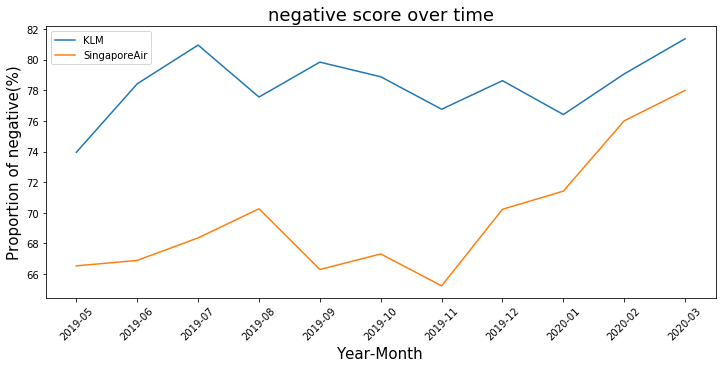

In [15]:
# Sentimental score plot 

plt.figure(figsize=(12,5))
plt.plot(sent_time_k['negative']*100)
plt.plot(sent_time_s['negative']*100)
plt.xlabel("Year-Month", size=15)
plt.ylabel('Proportion of negative(%)', size=15)
plt.xticks(rotation='45')
plt.legend(['KLM','SingaporeAir'])
plt.title("negative score over time", size=18)
plt.savefig('Time series1.png', bbox_inches = 'tight')
plt.show()

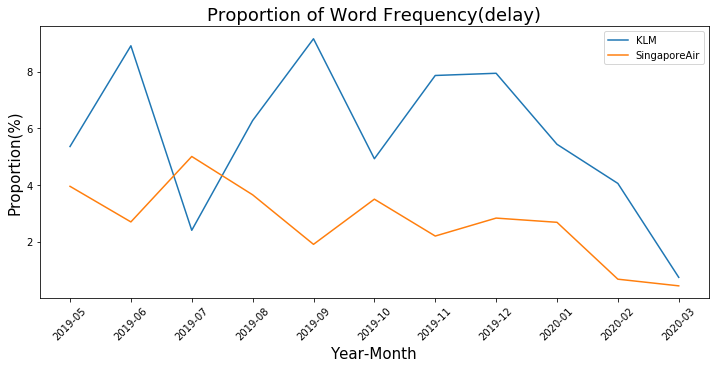

In [12]:
# Plot of word frequency(delay) of KLM and SingaporeAire over time(proportion)

delay_per_month['proportion'] = delay_per_month['date'] / KLM_per_month.size().to_frame('size')['size']
cancel_per_month['proportion'] = cancel_per_month['date'] / KLM_per_month.size().to_frame('size')['size']


delay_per_month_singapore['proportion'] = delay_per_month_singapore['date'] / singapore_per_month.size().to_frame('size')['size']
cancel_per_month_singapore['proportion'] = cancel_per_month_singapore['date'] / singapore_per_month.size().to_frame('size')['size']


plt.figure(figsize=(12,5))
plt.plot(delay_per_month['proportion']*100)
plt.plot(delay_per_month_singapore['proportion']*100)
plt.xlabel("Year-Month", size=15)
plt.ylabel('Proportion(%)', size=15)
plt.xticks(rotation='45')
plt.title("Proportion of Word Frequency(delay)", size=18)
plt.legend(['KLM','SingaporeAir'])


plt.savefig('Time series2.png', bbox_inches = 'tight')

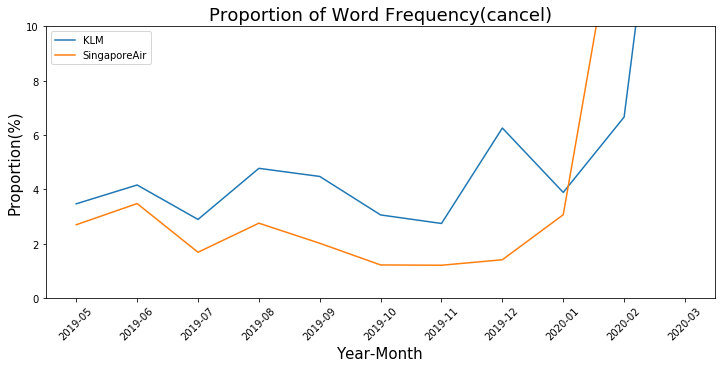

In [13]:
# Plot of word frequency(cancel) of KLM and SingaporeAir over time(proportion)

plt.figure(figsize=(12,5))
plt.plot(cancel_per_month['proportion']*100)
plt.plot(cancel_per_month_singapore['proportion']*100)
plt.xlabel("Year-Month", size=15)
plt.ylabel('Proportion(%)', size=15)
plt.xticks(rotation='45')
plt.title("Proportion of Word Frequency(cancel)", size=18)
plt.legend(['KLM','SingaporeAir'])
plt.ylim([0,10])


plt.savefig('Time series3.png', bbox_inches = 'tight')

In [ ]:
# Results
"""
1. Onward 2020-01, negative scores of both airlines increased (perhaps due to the corona issue). 
   But SingaporeAir attained less negative score than KLM.
   
2. SingaporeAir's 'delay proportion' is generally lower as well. So does 'cancel proportion'.

3. Onward 2020-01, SingaporeAir's 'cancel proporiton' was higher.(Perhaps corona occurred first in Asia)

4. August and September are not peak holiday season in singapore since hot and humid weather is not preferable for travellers.
   Therefore, while 'delay proportion' of KLM increased between August and September(August and September are peak holiday season 
   of the netherlands and its neighbor countries), SingaporeAir's 'delay proportion' decreased.
   This pattern is observed as well in 'cancel proportion' and 'negative score' plot.

5. 'Delay porportion' decreased rapidly onward 2020-01 because many flights were cancelled due to travel restrictions related to the
    the corona virus.
   
"""